<a href="https://colab.research.google.com/github/Hapaydin/decompose/blob/main/DeCmps_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Singular Spectrum Analysis for Time Series in Python

Import the main library and pandas and numpy for use outside the main library.

In [47]:
from google.colab import drive 
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/myLibDirectory')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
from datetime import datetime
import pandas as pd
import numpy as np

In [49]:
import importlib
import os
import sys
os.system('/content/gdrive/My Drive/Colab Notebooks/myLibDirectory/mySSA.py')
AI_Method = "/content/gdrive/My Drive/Colab Notebooks/ssa/"

In [50]:
from mySSA import mySSA

In [51]:
ts=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/12188QMssa2.csv', delimiter=';', parse_dates=True, index_col='Month')
print (ts[0:5])
K = 30
FileName = "SSA-w"+str(K)+"-"+str(datetime.now()).replace(":", ".")
suspected_seasonality = 30

              QM
Month           
1996-10-01  0.75
1996-11-01  0.72
1996-12-01  0.79
1997-01-01  1.39
1997-02-01  1.39


Instantiate the ssa object with the time series

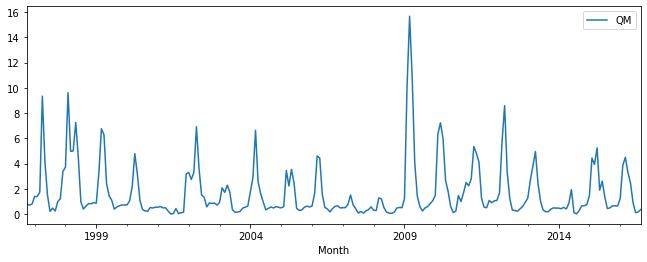

In [52]:
ts.plot()

In [53]:
ssa = mySSA(ts)

The methods and attributes currently associated with the object is listed below:

In [54]:
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

In [55]:
ssa.embed(embedding_dimension=30, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  30
Trajectory dimensions	: (30, 211)
Complete dimension	: (30, 211)
Missing dimension     	: (30, 0)


In [56]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 30
Dimension of projection space	: 30
Characteristic of projection	: 1.0


In [57]:
s_contribut=ssa.s_contributions
print (s_contribut.dtypes)

Contribution    float64
dtype: object


In [58]:
l = dir(ssa)
print (l[K])

__reduce__


We can view the contribution of each of the signals (corresponding to each singular value) as follows:

In [59]:
from pprint import pprint
print(vars(ssa.s_contributions))

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['Contribution'], dtype='object')
Axis 1: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           dtype='int64')
FloatBlock: slice(0, 1, 1), 1 x 30, dtype: float64, '_item_cache': {}, '_attrs': {}}


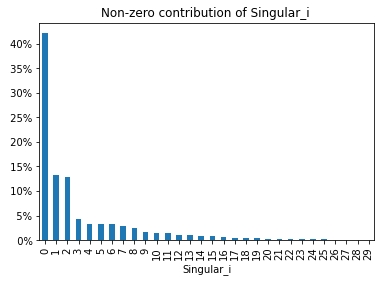

In [60]:
# First enable display of graphs in the notebook
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 4 #11,4
#rcParams['figure.xticks(np.arange(0, K+1, step=5))']
ssa.view_s_contributions()


From the above we can see that most of the variation is contained in the first signal (corresponding to the first singular vector).  The scale in the image above makes it difficult to see what's going on with the remaining singular values.  

Pass the argument  `adjust_scale=True` to see the eigenvalue groupings more clearly.  The scale on the y-axis is meaningless and is removed in this case.

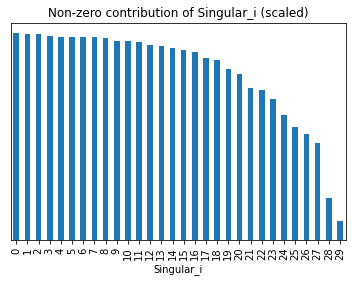

In [61]:
ssa.view_s_contributions(adjust_scale=True)

Now that we have the signal components (there are 15 additive components to the signal) we can loop over that range and look at each one individually.  We only look at the first 5 elements below:

*The additive signal elements are stored in the* `object.Xs` *dictionary.*

In [62]:
print (ts.shape)

(240, 1)


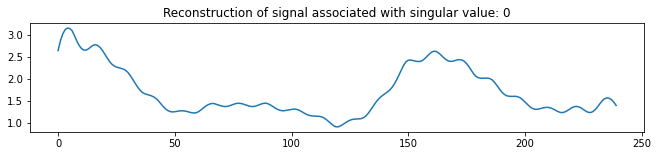

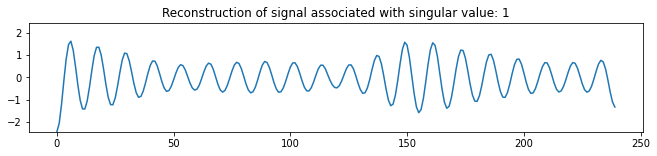

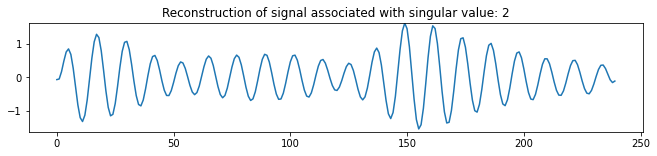

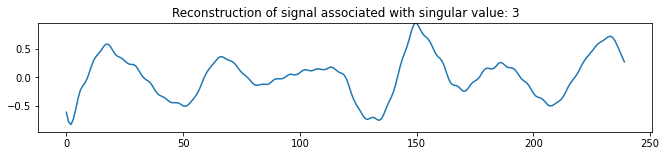

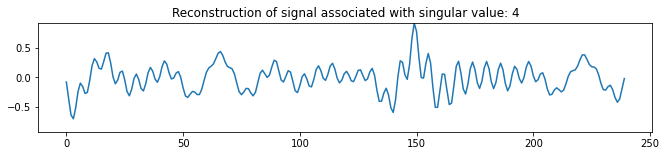

In [63]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

Let's see the result if we reconstruct the signal from these 5 streams.  We add the first 5 signals and pass the result to `object.view_reconstruction`:

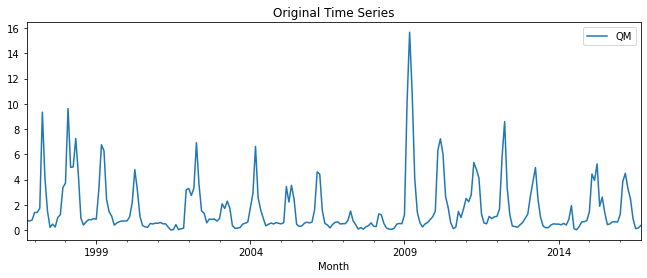

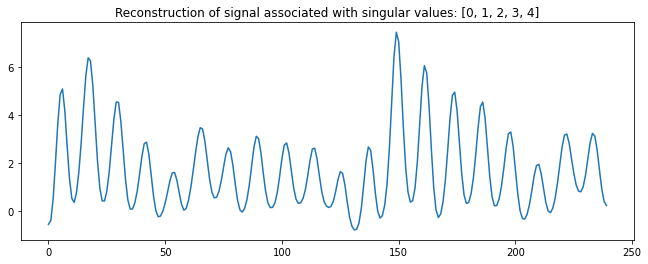

In [64]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

We see that the reconstruction looks pretty good already! Let's plot it on the same graph:

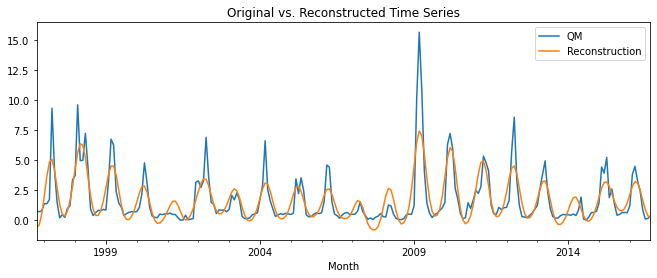

In [65]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

That looks very reasonable! We can get closer to the original series by adding additional signals from the remaining singular values.  Let's use the first 10 singular values:

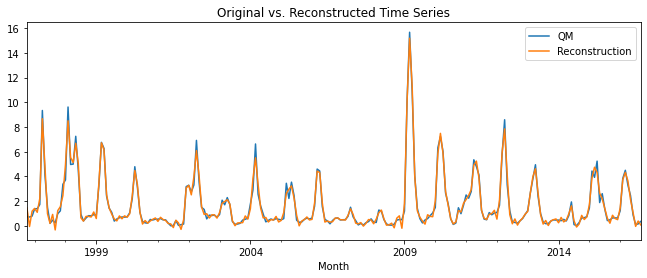

In [66]:
streams10 = [i for i in range(20)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

To forecast using only some of the singular values, pass the list of singular value indices to be used to the `forecast_recurrent` method:

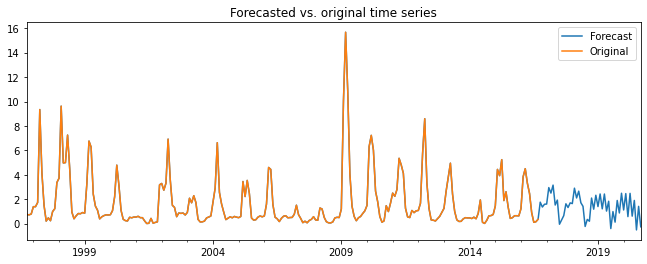

In [67]:
ssa.forecast_recurrent(steps_ahead=48, singular_values=streams10, plot=True)

That concludes our example.  As a demonstration of how powerful this technique is, let's forecast this series 1x the length of the original time series:

In [68]:
import math 

s_contribut=ssa.s_contributions
s_contribut['log_value'] = np.log10(s_contribut['Contribution']*100)
print ((s_contribut[0:10]))
s_contribut['log_value'].plot 

   Contribution  log_value
0        0.4214   1.624695
1        0.1326   1.122544
2        0.1281   1.107549
3        0.0434   0.637490
4        0.0334   0.523746
5        0.0332   0.521138
6        0.0319   0.503791
7        0.0295   0.469822
8        0.0251   0.399674
9        0.0162   0.209515


No handles with labels found to put in legend.


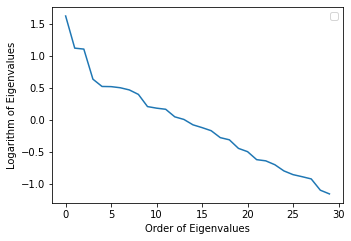

In [69]:
import matplotlib.pyplot as pyplot
pyplot.figure(figsize=(5.2, 3.6))
pyplot.plot(s_contribut['log_value'], label='')
#pyplot.plot([x for x in s_contribut['log_value']], 'y', label='Test')
pyplot.xlabel('Order of Eigenvalues')
pyplot.ylabel('Logarithm of Eigenvalues')
pyplot.title ('')
pyplot.legend()
pyplot.xticks(np.arange(0, K+1, step=5))

pyplot.savefig(AI_Method+FileName+'e.png', dpi=75)
#pyplot.show()

Month
1996-10-01   -2.513090
1996-11-01   -2.119027
1996-12-01   -1.047639
1997-01-01    0.337751
1997-02-01    1.587275
                ...   
2016-05-01    0.655769
2016-06-01   -0.010518
2016-07-01   -0.724610
2016-08-01   -1.258112
2016-09-01   -1.438855
Name: Reconstruction, Length: 240, dtype: float64


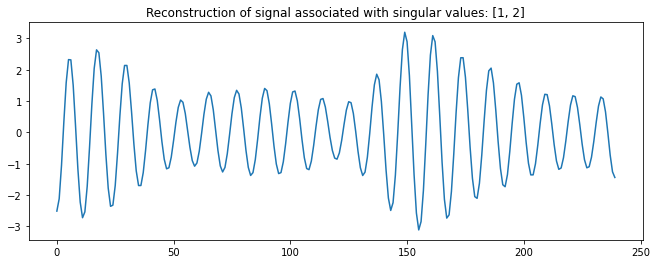

In [70]:
streamsB = [i for i in range(1,3)]
reconstructedB = ssa.view_reconstruction(*[ssa.Xs[i] for i in streamsB], names=streamsB, return_df=True)

ts_copyB = ssa.ts.copy()
ts_copyB['Reconstruction'] = reconstructedB.Reconstruction.values
print(ts_copyB['Reconstruction'])

In [71]:

print (AI_Method+FileName)

/content/gdrive/My Drive/Colab Notebooks/ssa/SSA-w30-2021-04-13 17.21.32.669796
